In [1]:
import scipy.io
import numpy as np
import pandas as pd
import os
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

# Ignore all warnings
warnings.filterwarnings('ignore')

In [2]:
meta_path = "/kaggle/input/stanford-cars-dataset/car_devkit/devkit/cars_meta.mat"
train_annos_path = "/kaggle/input/stanford-cars-dataset/car_devkit/devkit/cars_train_annos.mat"

meta = scipy.io.loadmat(meta_path)
raw_classes = meta['class_names'].flatten()
class_names = [i.item() for i in raw_classes]

train_annos = scipy.io.loadmat(train_annos_path)
raw_annos = train_annos['annotations'][0]

data = []
for sample in raw_annos:
    fname = sample['fname'].item()
    class_id = sample['class'].item()
    class_name = class_names[class_id - 1]
    x1 = sample['bbox_x1'].item()
    y1 = sample['bbox_y1'].item()
    x2 = sample['bbox_x2'].item()
    y2 = sample['bbox_y2'].item()
    data.append([fname, class_id, class_name, x1, y1, x2, y2])

df_train = pd.DataFrame(data, columns=['filename', 'class_id', 'class_name', 'x1', 'y1', 'x2', 'y2'])
print(f"Total Images: {len(df_train)}")
print(f"Total Classes: {len(class_names)}")

Total Images: 8144
Total Classes: 196


In [3]:
class StanfordCarsDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row['filename'])
        image = Image.open(img_path).convert('RGB')
        
        image = image.crop((row['x1'], row['y1'], row['x2'], row['y2']))
        
        label = int(row['class_id']) - 1
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [4]:
# I changed the image size to 224x224 because thats the default
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomRotation(10), # removed the flip and added rotation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
images_root = '/kaggle/input/stanford-cars-dataset/cars_train/cars_train'

# Split: 70% Train, 15% Val, 15% Test
train_df, test_df1 = train_test_split(
    df_train, 
    test_size=0.3, 
    random_state=42, 
    stratify=df_train['class_id']
)

test_df, val_df = train_test_split(
    test_df1, 
    test_size=0.5, 
    random_state=42, 
    stratify=test_df1['class_id']
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Testing samples: {len(test_df)}")

# Create datasets
train_ds = StanfordCarsDataset(train_df, images_root, transform=train_transforms)
val_ds = StanfordCarsDataset(val_df, images_root, transform=test_transforms)  # Fix #2
test_ds = StanfordCarsDataset(test_df, images_root, transform=test_transforms)

# Create dataloaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)

Training samples: 5700
Validation samples: 1222
Testing samples: 1222


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)

num_labels = len(class_names)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_labels)


model = model.to(device)
print(f"Model ready: Inception V1 for {num_labels} classes")

Using device: cuda


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 203MB/s]


Model ready: Inception V1 for 196 classes


In [7]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, path='best_checkpoint.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)
        print(f'Validation loss improved. Saving model...')

In [8]:
print("\n" + "="*70)
print("Training: Fine-tuning all layers at once")
print("="*70)

for param in model.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()

optimizer_phase2 = optim.Adam(model.parameters(), lr=1e-4)
scheduler_phase2 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_phase2, mode='min', factor=0.1, patience=2, verbose=True
)
early_stopper_phase2 = EarlyStopping(patience=5, path='Inception_V1_weights.pth')

num_epochs_phase2 = 15

for epoch in range(num_epochs_phase2):
    print(f"\n=== Phase 2 - Epoch {epoch+1}/{num_epochs_phase2} ===")
    
    model.train()
    train_loss = 0
    train_correct = 0
    
    loop = tqdm(train_loader, desc="Training")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        
        optimizer_phase2.zero_grad()
        
        if model.training and hasattr(model, 'aux_logits') and model.aux_logits:
            outputs, aux2, aux1 = model(images)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux2, labels)
            loss3 = criterion(aux1, labels)
            loss = loss1 + 0.3 * loss2 + 0.3 * loss3
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer_phase2.step()
        
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        
        loop.set_postfix(loss=loss.item())
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    
    model.eval()
    val_loss = 0
    val_correct = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
    
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)
    
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {avg_val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    
    scheduler_phase2.step(avg_val_loss)
    early_stopper_phase2(avg_val_loss, model)
    
    if early_stopper_phase2.early_stop:
        print("Phase 2 early stopping triggered!")
        break

model.load_state_dict(torch.load('Inception_V1_weights.pth'))
print("Phase 2 complete. Loaded best weights.")


Training: Fine-tuning all layers at once

=== Phase 2 - Epoch 1/15 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 5.1749 | Train Acc: 0.0240
Val Loss:   4.8711 | Val Acc:   0.0835
Validation loss improved. Saving model...

=== Phase 2 - Epoch 2/15 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 4.5217 | Train Acc: 0.1477
Val Loss:   4.1477 | Val Acc:   0.2553
Validation loss improved. Saving model...

=== Phase 2 - Epoch 3/15 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 3.7881 | Train Acc: 0.3140
Val Loss:   3.4197 | Val Acc:   0.3830
Validation loss improved. Saving model...

=== Phase 2 - Epoch 4/15 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 3.0795 | Train Acc: 0.4754
Val Loss:   2.7657 | Val Acc:   0.5033
Validation loss improved. Saving model...

=== Phase 2 - Epoch 5/15 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 2.4381 | Train Acc: 0.6158
Val Loss:   2.2229 | Val Acc:   0.6137
Validation loss improved. Saving model...

=== Phase 2 - Epoch 6/15 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.8871 | Train Acc: 0.7309
Val Loss:   1.7922 | Val Acc:   0.6800
Validation loss improved. Saving model...

=== Phase 2 - Epoch 7/15 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.4161 | Train Acc: 0.8042
Val Loss:   1.4813 | Val Acc:   0.7242
Validation loss improved. Saving model...

=== Phase 2 - Epoch 8/15 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.0573 | Train Acc: 0.8633
Val Loss:   1.2481 | Val Acc:   0.7439
Validation loss improved. Saving model...

=== Phase 2 - Epoch 9/15 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.7892 | Train Acc: 0.8975
Val Loss:   1.0385 | Val Acc:   0.7905
Validation loss improved. Saving model...

=== Phase 2 - Epoch 10/15 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.5791 | Train Acc: 0.9272
Val Loss:   0.9425 | Val Acc:   0.8101
Validation loss improved. Saving model...

=== Phase 2 - Epoch 11/15 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.4226 | Train Acc: 0.9567
Val Loss:   0.8258 | Val Acc:   0.8151
Validation loss improved. Saving model...

=== Phase 2 - Epoch 12/15 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.3070 | Train Acc: 0.9653
Val Loss:   0.7711 | Val Acc:   0.8175
Validation loss improved. Saving model...

=== Phase 2 - Epoch 13/15 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.2257 | Train Acc: 0.9756
Val Loss:   0.7352 | Val Acc:   0.8159
Validation loss improved. Saving model...

=== Phase 2 - Epoch 14/15 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.1661 | Train Acc: 0.9846
Val Loss:   0.7207 | Val Acc:   0.8249
Validation loss improved. Saving model...

=== Phase 2 - Epoch 15/15 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.1198 | Train Acc: 0.9870
Val Loss:   0.6936 | Val Acc:   0.8265
Validation loss improved. Saving model...
Phase 2 complete. Loaded best weights.


In [9]:
def evaluate_model(model, loader, device):
    model.eval()
    correct_1 = 0
    correct_5 = 0
    total = 0
    total_loss = 0  # Add this
    all_preds = []
    all_labels = []
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # --- Log Loss Calculation ---
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            
            # --- Top-1 Accuracy ---
            _, pred_1 = torch.max(outputs, 1)
            correct_1 += (pred_1 == labels).sum().item()
            
            # --- Top-5 Accuracy ---
            _, pred_5 = outputs.topk(5, 1, largest=True, sorted=True)
            correct_5 += (pred_5 == labels.view(-1, 1)).sum().item()
            
            total += labels.size(0)
            all_preds.extend(pred_1.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    top1_acc = correct_1 / total
    top5_acc = correct_5 / total
    log_loss = total_loss / total
    
    return top1_acc, top5_acc, log_loss, all_labels, all_preds

device = torch.device("cuda")
model.load_state_dict(torch.load('Inception_V1_weights.pth'))
acc_1, acc_5, logloss, y_true, y_pred = evaluate_model(model, test_loader, device)

print("-" * 30)
print(f"Top-1 Accuracy: {acc_1*100:.2f}%")
print(f"Top-5 Accuracy: {acc_5*100:.2f}%")
print("-" * 30)
print(f"Log Loss: {logloss:.4f}")  # Fixed
print("-" * 30)

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

------------------------------
Top-1 Accuracy: 82.90%
Top-5 Accuracy: 96.15%
------------------------------
Log Loss: 0.6708
------------------------------


In [10]:
from sklearn.metrics import classification_report

print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


DETAILED CLASSIFICATION REPORT
                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000     0.8750    1.0000    0.9333         7
                                   Acura RL Sedan 2012     0.8000    0.8000    0.8000         5
                                   Acura TL Sedan 2012     0.8571    1.0000    0.9231         6
                                  Acura TL Type-S 2008     0.8333    0.8333    0.8333         6
                                  Acura TSX Sedan 2012     1.0000    0.8333    0.9091         6
                             Acura Integra Type R 2001     0.7500    0.5000    0.6000         6
                              Acura ZDX Hatchback 2012     0.7500    1.0000    0.8571         6
              Aston Martin V8 Vantage Convertible 2012     0.6667    0.5714    0.6154         7
                    Aston Martin V8 Vantage Coupe 2012     1.0000    0.1667    0.2857         6
       


SAMPLE MISCLASSIFICATIONS


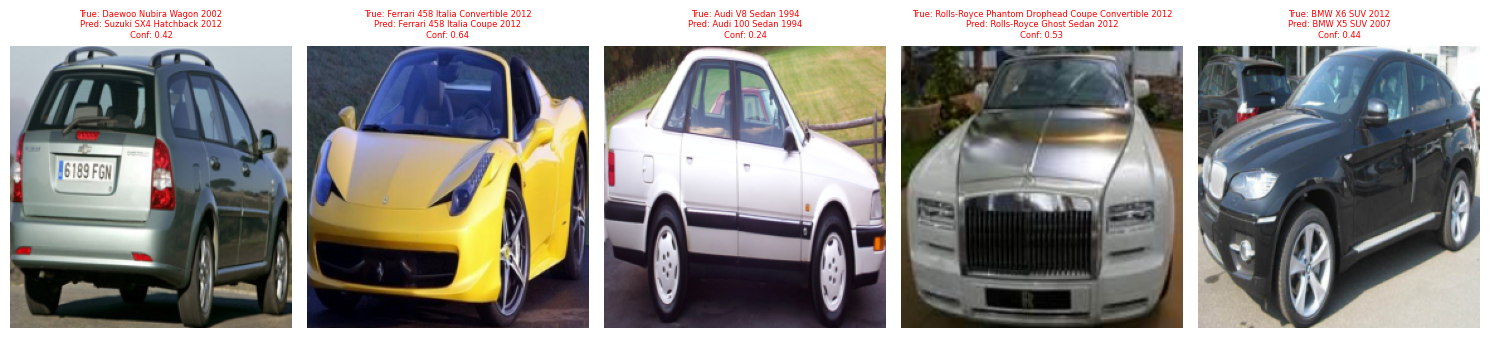

In [11]:
import matplotlib.pyplot as plt

def visualize_failures(model, loader, device, num_images=5):
    model.eval()
    images_shown = 0
    
    plt.figure(figsize=(15, 10))
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs, preds = torch.max(torch.softmax(outputs, dim=1), 1)
            
            for i in range(len(images)):
                if preds[i] != labels[i]:
                    if images_shown >= num_images:
                        plt.tight_layout()
                        plt.show()
                        return
                    
                    # Undo normalization
                    img = images[i].cpu().permute(1, 2, 0).numpy()
                    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
                    img = np.clip(img, 0, 1)
                    
                    true_name = class_names[labels[i].item()]
                    pred_name = class_names[preds[i].item()]
                    confidence = probs[i].item()
                    
                    ax = plt.subplot(1, num_images, images_shown + 1)
                    plt.imshow(img)
                    plt.title(f"True: {true_name}\nPred: {pred_name}\nConf: {confidence:.2f}", 
                             fontsize=6, color='red')
                    plt.axis('off')
                    
                    images_shown += 1
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*70)
print("SAMPLE MISCLASSIFICATIONS")
print("="*70)
visualize_failures(model, test_loader, device, num_images=5)

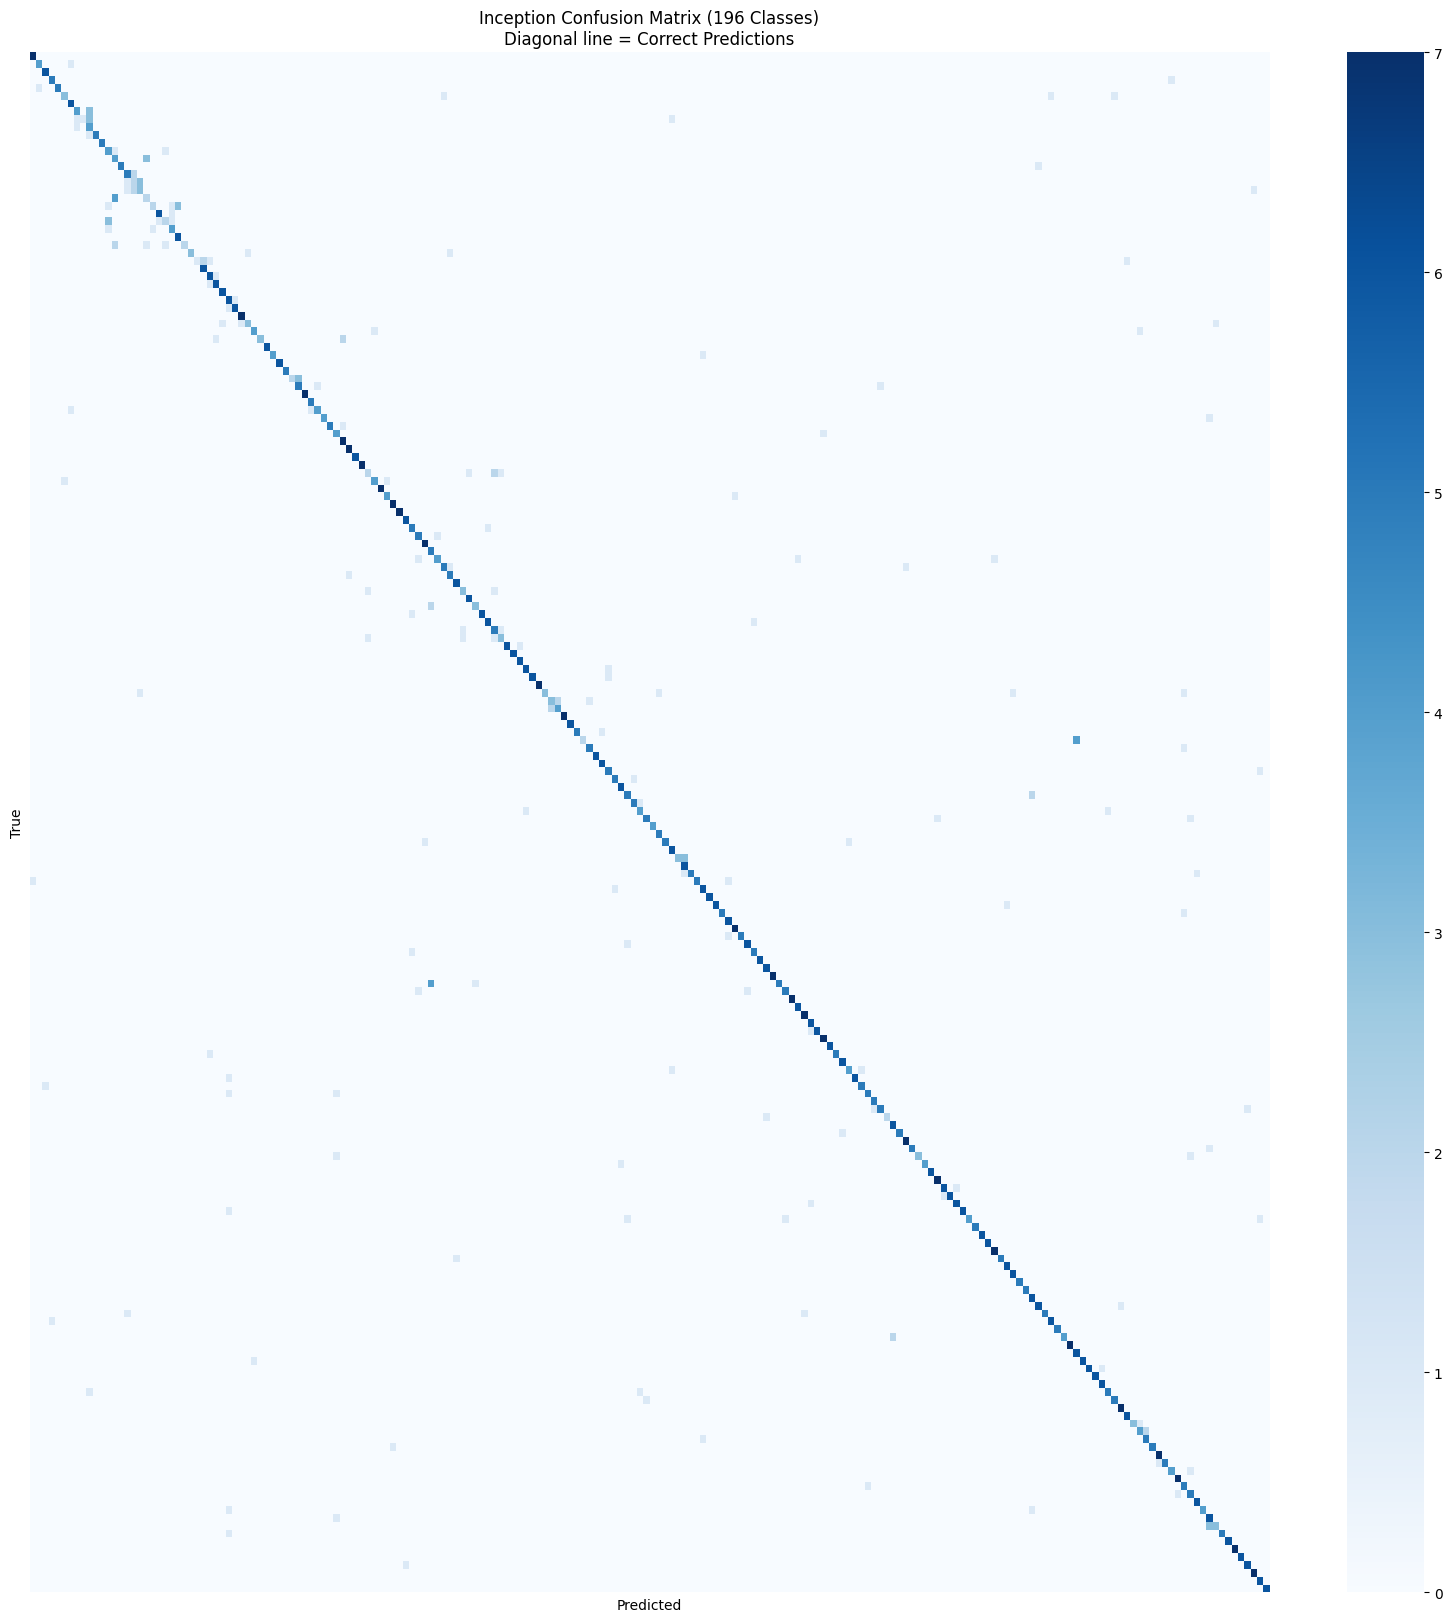

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=False, yticklabels=False) # Labels hidden for clarity

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Inception Confusion Matrix (196 Classes)\nDiagonal line = Correct Predictions')
plt.show()

Getting Probabilities:   0%|          | 0/39 [00:00<?, ?it/s]

--------------------------------------------------
Macro-Average AUC: 0.9980
Micro-Average AUC: 0.9979
Average per-class AUC: 0.9978
--------------------------------------------------


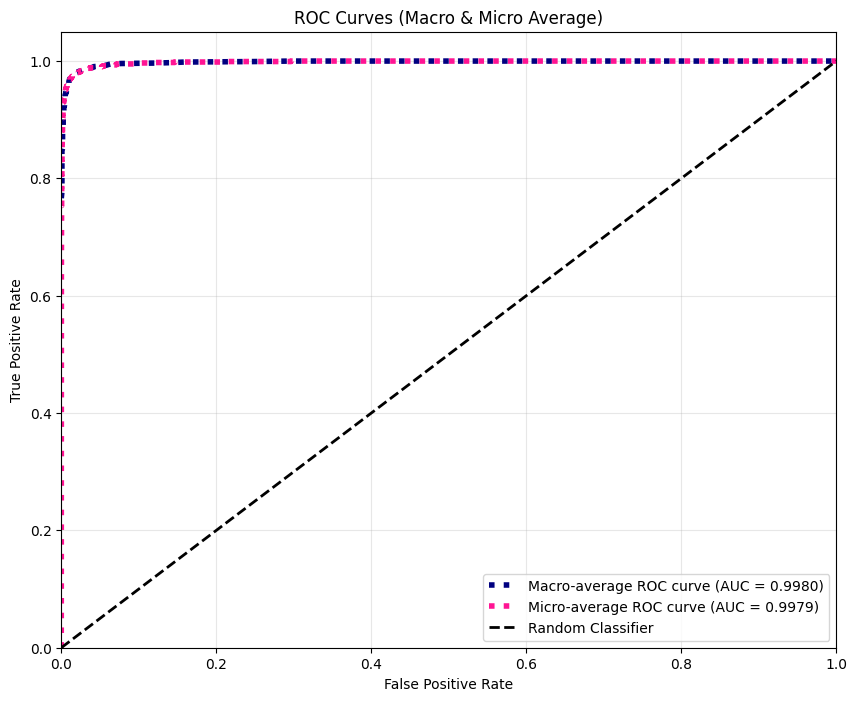

In [13]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score

def get_all_probs(model, loader, device):
    model.eval()
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Getting Probabilities"):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.numpy())
    
    return np.concatenate(all_probs), np.concatenate(all_labels)

y_probs, y_test_np = get_all_probs(model, test_loader, device)

n_classes = len(class_names)
y_test_bin = label_binarize(y_test_np, classes=range(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Alternative: Using sklearn's built-in functions
macro_auc = roc_auc_score(y_test_bin, y_probs, average='macro')
micro_auc = roc_auc_score(y_test_bin, y_probs, average='micro')

# Print AUC values
print("-" * 50)
print(f"Macro-Average AUC: {roc_auc['macro']:.4f}")
print(f"Micro-Average AUC: {roc_auc['micro']:.4f}")
print(f"Average per-class AUC: {np.mean(list(roc_auc[i] for i in range(n_classes))):.4f}")
print("-" * 50)

# Plotting
plt.figure(figsize=(10, 8))

plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:.4f})',
         color='navy', linestyle=':', linewidth=4)

plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Macro & Micro Average)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


Highest AUC Scores (Best Performing Classes)
1.0000 | AM General Hummer SUV 2000
1.0000 | Acura RL Sedan 2012
1.0000 | Acura TL Sedan 2012
1.0000 | Acura ZDX Hatchback 2012
1.0000 | Audi RS 4 Convertible 2008
1.0000 | BMW 6 Series Convertible 2007
1.0000 | BMW M3 Coupe 2012
1.0000 | BMW Z4 Convertible 2012
1.0000 | Bentley Arnage Sedan 2009
1.0000 | Bentley Mulsanne Sedan 2011

Lowest AUC Scores (Worst Performing Classes)
0.9916 | Toyota Sequoia SUV 2012
0.9910 | Hyundai Tucson SUV 2012
0.9879 | Acura Integra Type R 2001
0.9878 | Buick Verano Sedan 2012
0.9872 | Suzuki Aerio Sedan 2007
0.9822 | Daewoo Nubira Wagon 2002
0.9687 | Hyundai Elantra Sedan 2007
0.9680 | Infiniti G Coupe IPL 2012
0.9578 | Audi TT RS Coupe 2012
0.9478 | Dodge Caliber Wagon 2012

AUC Statistics
Mean AUC:   0.9978
Median AUC: 0.9997
Std Dev:    0.0061
Min AUC:    0.9478
Max AUC:    1.0000

Performance Distribution:
  Excellent (≥0.90): 196 classes
  Good (0.80-0.89):  0 classes
  Fair (0.70-0.79):  0 classes
  P

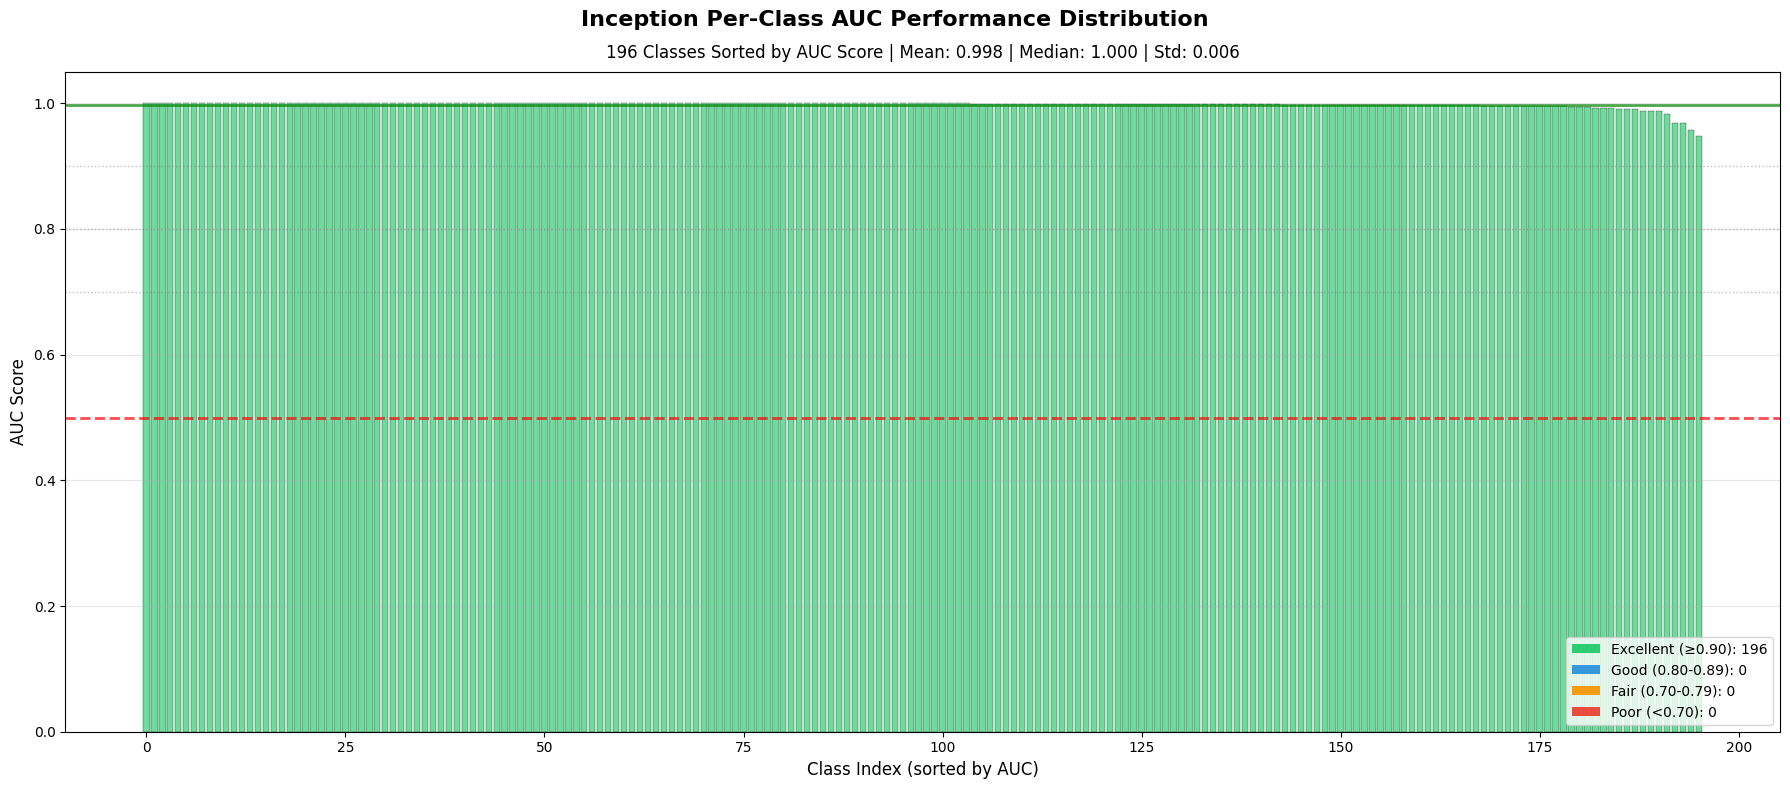

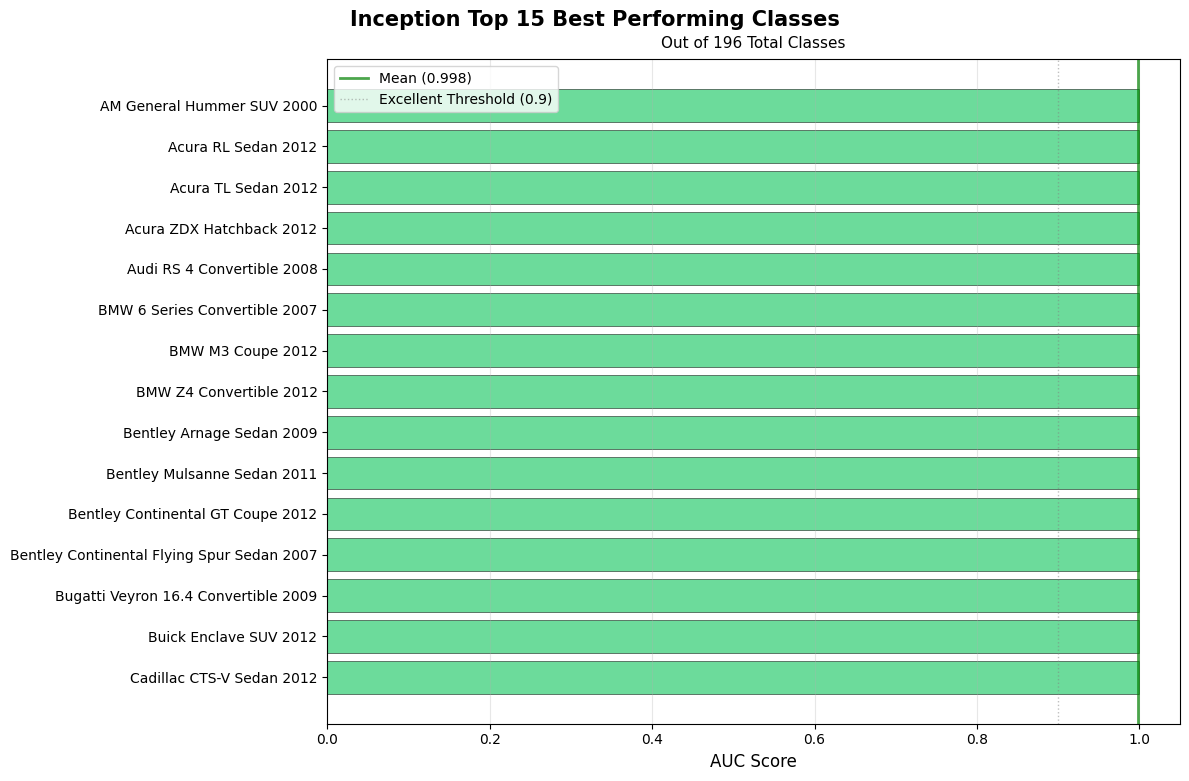

In [14]:
import matplotlib.pyplot as plt
import numpy as np

auc_scores = []
for i in range(len(class_names)):
    auc_scores.append((class_names[i], roc_auc[i]))
auc_scores.sort(key=lambda x: x[1], reverse=True)

print("\n" + "="*50)
print("Highest AUC Scores (Best Performing Classes)")
print("="*50)
for name, score in auc_scores[:10]:
    print(f"{score:.4f} | {name}")

print("\n" + "="*50)
print("Lowest AUC Scores (Worst Performing Classes)")
print("="*50)
for name, score in auc_scores[-10:]:
    print(f"{score:.4f} | {name}")

auc_values = [score for name, score in auc_scores]
mean_auc = np.mean(auc_values)
median_auc = np.median(auc_values)
std_auc = np.std(auc_values)

print("\n" + "="*50)
print("AUC Statistics")
print("="*50)
print(f"Mean AUC:   {mean_auc:.4f}")
print(f"Median AUC: {median_auc:.4f}")
print(f"Std Dev:    {std_auc:.4f}")
print(f"Min AUC:    {min(auc_values):.4f}")
print(f"Max AUC:    {max(auc_values):.4f}")


excellent = sum(1 for score in auc_values if score >= 0.9)
good = sum(1 for score in auc_values if 0.8 <= score < 0.9)
fair = sum(1 for score in auc_values if 0.7 <= score < 0.8)
poor = sum(1 for score in auc_values if score < 0.7)

print(f"\nPerformance Distribution:")
print(f"  Excellent (≥0.90): {excellent} classes")
print(f"  Good (0.80-0.89):  {good} classes")
print(f"  Fair (0.70-0.79):  {fair} classes")
print(f"  Poor (<0.70):      {poor} classes")

plt.figure(figsize=(18, 8))


class_indices = np.arange(len(auc_scores))
scores = [score for name, score in auc_scores]
names = [name for name, score in auc_scores]


colors = []
for score in scores:
    if score >= 0.9:
        colors.append('#2ecc71')  # Green for excellent
    elif score >= 0.8:
        colors.append('#3498db')  # Blue for good
    elif score >= 0.7:
        colors.append('#f39c12')  # Orange for fair
    else:
        colors.append('#e74c3c')  # Red for poor

plt.bar(class_indices, scores, color=colors, alpha=0.7, edgecolor='black', linewidth=0.3)

# Add reference lines
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Random (0.5)', alpha=0.7)
plt.axhline(y=mean_auc, color='green', linestyle='-', linewidth=2, label=f'Mean ({mean_auc:.3f})', alpha=0.7)
plt.axhline(y=0.7, color='gray', linestyle=':', linewidth=1, alpha=0.5)
plt.axhline(y=0.8, color='gray', linestyle=':', linewidth=1, alpha=0.5)
plt.axhline(y=0.9, color='gray', linestyle=':', linewidth=1, alpha=0.5)

plt.suptitle('Inception Per-Class AUC Performance Distribution', fontsize=16, fontweight='bold', y=0.98)
plt.title(f'{len(class_names)} Classes Sorted by AUC Score | Mean: {mean_auc:.3f} | Median: {median_auc:.3f} | Std: {std_auc:.3f}', 
          fontsize=12, pad=10)
plt.xlabel('Class Index (sorted by AUC)', fontsize=12)
plt.ylabel('AUC Score', fontsize=12)
plt.ylim(0, 1.05)
plt.grid(axis='y', alpha=0.3)


from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', label=f'Excellent (≥0.90): {excellent}'),
    Patch(facecolor='#3498db', label=f'Good (0.80-0.89): {good}'),
    Patch(facecolor='#f39c12', label=f'Fair (0.70-0.79): {fair}'),
    Patch(facecolor='#e74c3c', label=f'Poor (<0.70): {poor}')
]
plt.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 8))

top_15_scores = scores[:15]
top_15_names = names[:15]
top_15_colors = colors[:15]
y_pos = np.arange(15)

plt.barh(y_pos, top_15_scores, color=top_15_colors, alpha=0.7, edgecolor='black', linewidth=0.5)
plt.yticks(y_pos, top_15_names, fontsize=10)
plt.axvline(x=mean_auc, color='green', linestyle='-', linewidth=2, label=f'Mean ({mean_auc:.3f})', alpha=0.7)
plt.axvline(x=0.9, color='gray', linestyle=':', linewidth=1, alpha=0.5, label='Excellent Threshold (0.9)')
plt.xlabel('AUC Score', fontsize=12)
plt.xlim(0, 1.05)
plt.legend(fontsize=10)
plt.grid(axis='x', alpha=0.3)
plt.gca().invert_yaxis()

plt.suptitle('Inception Top 15 Best Performing Classes', fontsize=15, fontweight='bold', y=0.97)
plt.title(f'Out of {len(class_names)} Total Classes', fontsize=11, pad=8)
plt.tight_layout()
plt.show()

In [15]:
import torch.nn.functional as F
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.depthwise = nn.Conv2d(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            groups=in_channels,
            bias=False #turned off since the btach norm will add bias
        )
        self.bn1 = nn.BatchNorm2d(in_channels)
        
        self.pointwise = nn.Conv2d(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.bn1(x)
        x = F.relu6(x) # orignial paper uses relu6
        
        x = self.pointwise(x)
        x = self.bn2(x)
        x = F.relu6(x)
        return x


class MobileNet(nn.Module):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.dw_conv2 = DepthwiseSeparableConv(32, 64, 1)
        self.dw_conv3 = DepthwiseSeparableConv(64, 128, 2)
        self.dw_conv4 = DepthwiseSeparableConv(128, 128, 1)
        self.dw_conv5 = DepthwiseSeparableConv(128, 256, 2)
        self.dw_conv6 = DepthwiseSeparableConv(256, 256, 1)
        self.dw_conv7 = DepthwiseSeparableConv(256, 512, 2)
        
        self.dw_conv8 = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv9 = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv10 = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv11 = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv12 = DepthwiseSeparableConv(512, 512, 1)
        
        self.dw_conv13 = DepthwiseSeparableConv(512, 1024, 2)
        self.dw_conv14 = DepthwiseSeparableConv(1024, 1024, 1)
        
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1024, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.dw_conv2(x)
        x = self.dw_conv3(x)
        x = self.dw_conv4(x)
        x = self.dw_conv5(x)
        x = self.dw_conv6(x)
        x = self.dw_conv7(x)
        x = self.dw_conv8(x)
        x = self.dw_conv9(x)
        x = self.dw_conv10(x)
        x = self.dw_conv11(x)
        x = self.dw_conv12(x)
        x = self.dw_conv13(x)
        x = self.dw_conv14(x)
        
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")
model_m = MobileNet(len(class_names));
model_m = model_m.to(device)
assert model_m.fc.out_features == len(class_names), "Model output doesn't match number of classes!"
print(f"Model ready: MobileNet V1 for {len(class_names)} classes")
model_m.load_state_dict(torch.load('/kaggle/input/mobilestan/pytorch/default/1/mobilenet_best.pth'))

Using device: cuda
Model ready: MobileNet V1 for 196 classes


<All keys matched successfully>

In [16]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    log_loss, roc_auc_score, top_k_accuracy_score
)
import torch
import numpy as np

def calculate_metrics(model, data_loader, device, num_classes):
    """
    Calculate comprehensive metrics for model evaluation.
    """
    model.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # Calculate metrics
    metrics = {
        # Top-1 accuracy (regular accuracy)
        'top1_accuracy': accuracy_score(all_labels, all_preds),
        
        # Top-5 accuracy
        'top5_accuracy': top_k_accuracy_score(all_labels, all_probs, k=5),
        
        # Precision (weighted average across all classes)
        'precision': precision_score(all_labels, all_preds, average='weighted', zero_division=0),
        
        # Recall (weighted average across all classes)
        'recall': recall_score(all_labels, all_preds, average='weighted', zero_division=0),
        
        # F1 Score (weighted average across all classes)
        'f1_score': f1_score(all_labels, all_preds, average='weighted', zero_division=0),
        
        # Log Loss
        'log_loss': log_loss(all_labels, all_probs),
        
        # AUC-ROC Macro (unweighted mean of all classes)
        'auc_roc_macro': roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro'),
        
        # AUC-ROC Weighted (weighted by class frequency)
        'auc_roc_weighted': roc_auc_score(all_labels, all_probs, multi_class='ovr', average='weighted')
    }
    
    return metrics


metrics_m = calculate_metrics(model_m, test_loader, device, num_classes=len(class_names))
metrics = calculate_metrics(model, test_loader, device, num_classes=len(class_names))

print('inc')
print(metrics)
print('mob')
print(metrics_m)




inc
{'top1_accuracy': 0.8289689034369886, 'top5_accuracy': 0.9615384615384616, 'precision': 0.8525643092132456, 'recall': 0.8289689034369886, 'f1_score': 0.8250870056939636, 'log_loss': 0.6708468446181045, 'auc_roc_macro': 0.9978393880262455, 'auc_roc_weighted': 0.9978804303555768}
mob
{'top1_accuracy': 0.6211129296235679, 'top5_accuracy': 0.8543371522094927, 'precision': 0.6481338878433804, 'recall': 0.6211129296235679, 'f1_score': 0.6158834627130291, 'log_loss': 1.5156906004314188, 'auc_roc_macro': 0.9889157126362409, 'auc_roc_weighted': 0.9888564205267546}


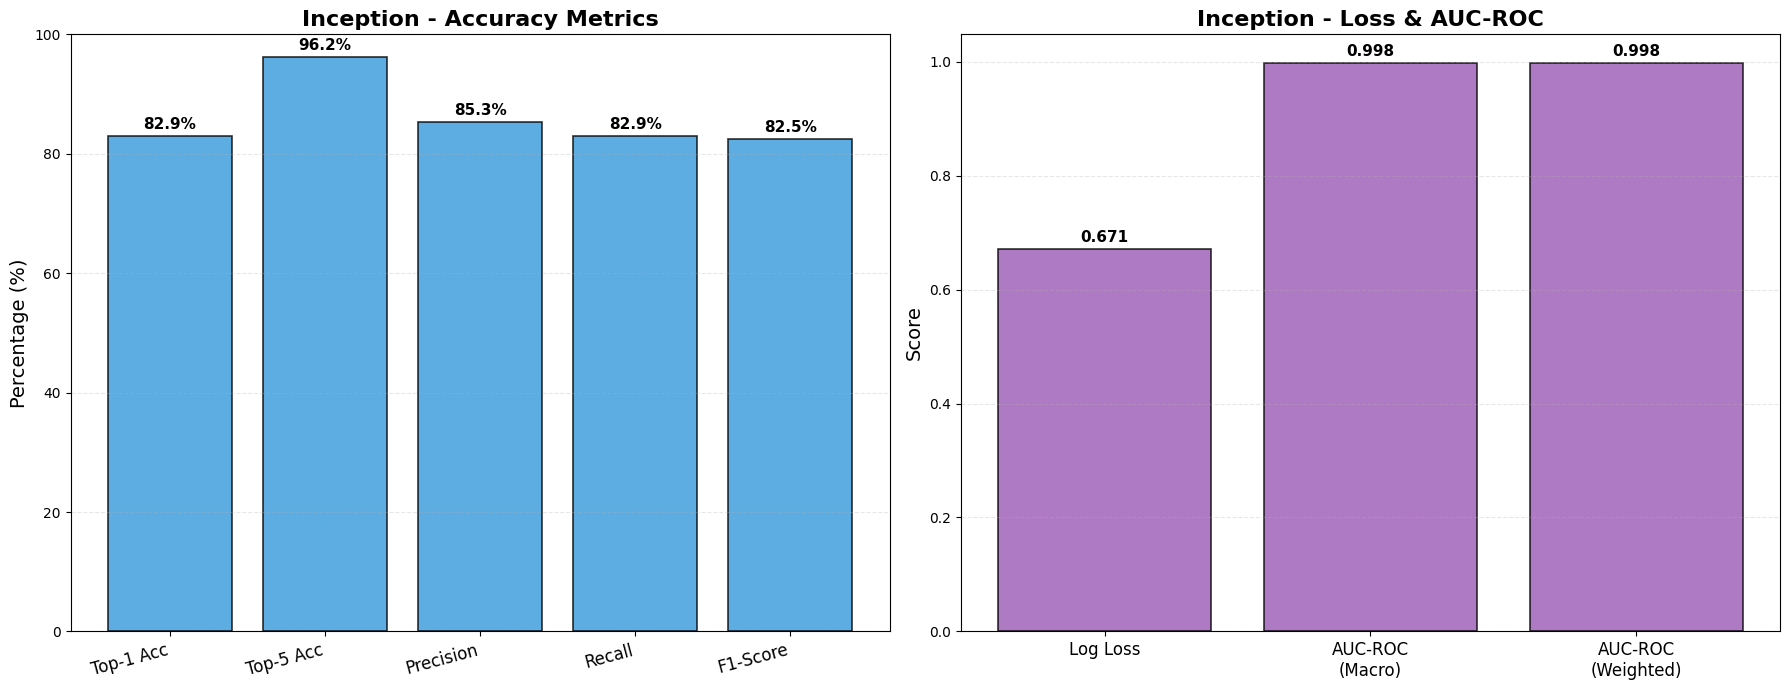

In [17]:
def plot_metrics_single_model(metrics, model_name='Model'):
    """
    Create a bar chart displaying metrics for a single model.
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))  # Increased from (14, 5) to (18, 7)
    
    # Accuracy metrics
    accuracy_metrics = ['top1_accuracy', 'top5_accuracy', 'precision', 'recall', 'f1_score']
    accuracy_labels = ['Top-1 Acc', 'Top-5 Acc', 'Precision', 'Recall', 'F1-Score']
    
    accuracy_values = [metrics[m] * 100 for m in accuracy_metrics]
    
    x = np.arange(len(accuracy_labels))
    
    bars1 = axes[0].bar(x, accuracy_values, color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.2)
    
    axes[0].set_ylabel('Percentage (%)', fontsize=14)  # Increased font size
    axes[0].set_title(f'{model_name} - Accuracy Metrics', fontsize=16, fontweight='bold')  # Increased font size
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(accuracy_labels, rotation=15, ha='right', fontsize=12)  # Added font size
    axes[0].set_ylim(0, 100)
    axes[0].grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        axes[0].annotate(f'{height:.1f}%', 
                        xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), 
                        textcoords="offset points", 
                        ha='center', 
                        va='bottom', 
                        fontsize=11,  # Increased font size
                        fontweight='bold')
    
    # Loss and AUC comparison
    other_metrics = ['log_loss', 'auc_roc_macro', 'auc_roc_weighted']
    other_labels = ['Log Loss', 'AUC-ROC\n(Macro)', 'AUC-ROC\n(Weighted)']
    
    other_values = [metrics[m] if metrics[m] else 0 for m in other_metrics]
    
    x2 = np.arange(len(other_labels))
    
    bars2 = axes[1].bar(x2, other_values, color='#9b59b6', alpha=0.8, edgecolor='black', linewidth=1.2)
    
    axes[1].set_ylabel('Score', fontsize=14)  # Increased font size
    axes[1].set_title(f'{model_name} - Loss & AUC-ROC', fontsize=16, fontweight='bold')  # Increased font size
    axes[1].set_xticks(x2)
    axes[1].set_xticklabels(other_labels, fontsize=12)  # Added font size
    axes[1].grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels
    for bar in bars2:
        height = bar.get_height()
        axes[1].annotate(f'{height:.3f}', 
                        xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), 
                        textcoords="offset points", 
                        ha='center', 
                        va='bottom', 
                        fontsize=11,  # Increased font size
                        fontweight='bold')
    
    plt.tight_layout()
    plt.show()



plot_metrics_single_model(metrics, model_name='Inception')

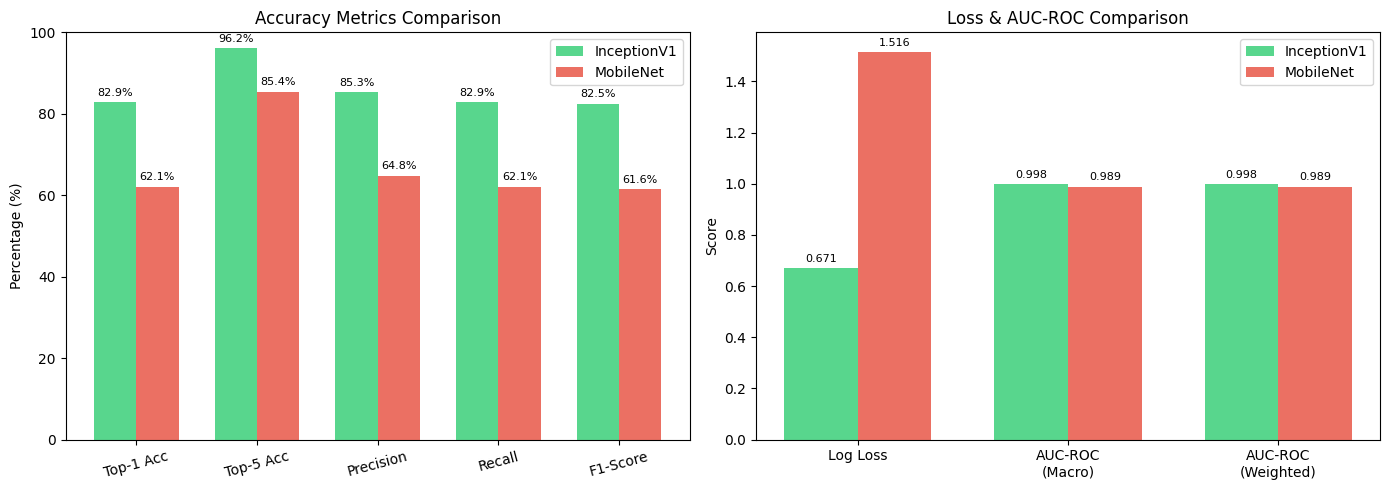

In [18]:
def plot_metrics_comparison(metrics_resnet, metrics_vgg, label, label_m):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy metrics comparison
    accuracy_metrics = ['top1_accuracy', 'top5_accuracy', 'precision', 'recall', 'f1_score']
    accuracy_labels = ['Top-1 Acc', 'Top-5 Acc', 'Precision', 'Recall', 'F1-Score']
    
    values = [metrics_resnet[m] * 100 for m in accuracy_metrics]
    values_ = [metrics_vgg[m] * 100 for m in accuracy_metrics]
    
    x = np.arange(len(accuracy_labels))
    width = 0.35
    
    bars1 = axes[0].bar(x - width/2, values, width, label=label, color='#2ecc71', alpha=0.8)
    bars2 = axes[0].bar(x + width/2, values_, width, label=label_m, color='#e74c3c', alpha=0.8)
    
    axes[0].set_ylabel('Percentage (%)')
    axes[0].set_title('Accuracy Metrics Comparison')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(accuracy_labels, rotation=15)
    axes[0].legend()
    axes[0].set_ylim(0, 100)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        axes[0].annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
    for bar in bars2:
        height = bar.get_height()
        axes[0].annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
    
    # Loss and AUC comparison
    other_metrics = ['log_loss', 'auc_roc_macro', 'auc_roc_weighted']
    other_labels = ['Log Loss', 'AUC-ROC\n(Macro)', 'AUC-ROC\n(Weighted)']
    
    other = [metrics_resnet[m] if metrics_resnet[m] else 0 for m in other_metrics]
    other_ = [metrics_vgg[m] if metrics_vgg[m] else 0 for m in other_metrics]
    
    x2 = np.arange(len(other_labels))
    
    bars3 = axes[1].bar(x2 - width/2, other, width, label=label, color='#2ecc71', alpha=0.8)
    bars4 = axes[1].bar(x2 + width/2, other_, width, label=label_m, color='#e74c3c', alpha=0.8)
    
    axes[1].set_ylabel('Score')
    axes[1].set_title('Loss & AUC-ROC Comparison')
    axes[1].set_xticks(x2)
    axes[1].set_xticklabels(other_labels)
    axes[1].legend()
    
    # Add value labels
    for bar in bars3:
        height = bar.get_height()
        axes[1].annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
    for bar in bars4:
        height = bar.get_height()
        axes[1].annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()


plot_metrics_comparison(metrics, metrics_m, 'InceptionV1','MobileNet')